# Seismic preconditionners

This tutorials provide an overview of the preconditionners available in JUDI. THese examples are useful, if not necessary, for FWI, RTM and LSRTM to improve convergence and the quality of the result. Preconditionners fall in two categories:
- *Model preconditioners*: these are linear operators that act on model domain vectors such as the velcoity or seismic image. 
- *Data preconditionners*: there are linear operators that act on the data, i.e the shot records.

We will show in the following example for both those categories. By design, the JUDI precontionners are designed to work on JUDI types such as `judiVector` or `PhysicalParameters` but can also be used directly on standard nion dimensional vectors.

## Setup

We setup this tutorial by creating a few objects we will be using. We consider 
- $d_{\text{obs}}$ a seismic dataset consiting of `nsrc` sources
- $m$ a squared slowness model
- $dm$ a model perturbation. For simplicity we derive this image directly for the squared slowness to avoid costly computation 

In [1]:
using JUDI, SlimPlotting, JLD2, HDF5, LinearAlgebra, SegyIO, Images
data_path = JUDI.JUDI_DATA

[ Info: Precompiling SlimPlotting [f6d04670-764e-495b-a720-91c3c9a588ff]


"/Users/mathiaslouboutin/.julia/dev/JUDI/src/../data"

### Model

In [2]:
n, d, o, m0, m = read(h5open("$(data_path)/overthrust_model.h5","r"), "n", "d", "o", "m0", "m");

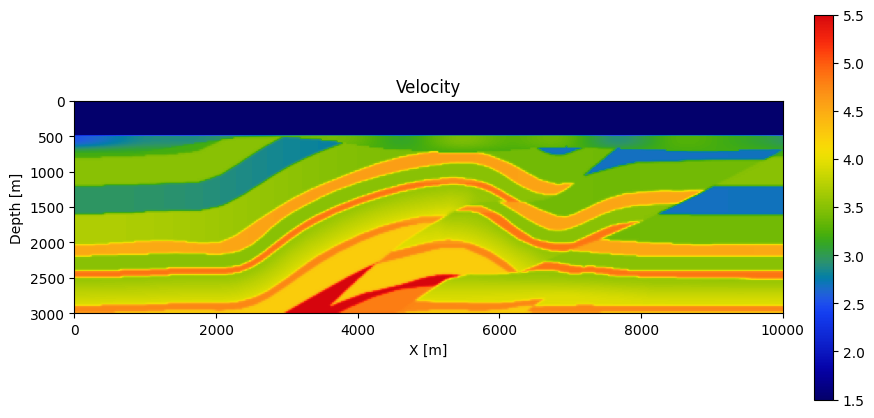

In [3]:
figure(figsize=(10, 5))
plot_velocity(m'.^(-.5), d; aspect=1, new_fig=false, cbar=true)

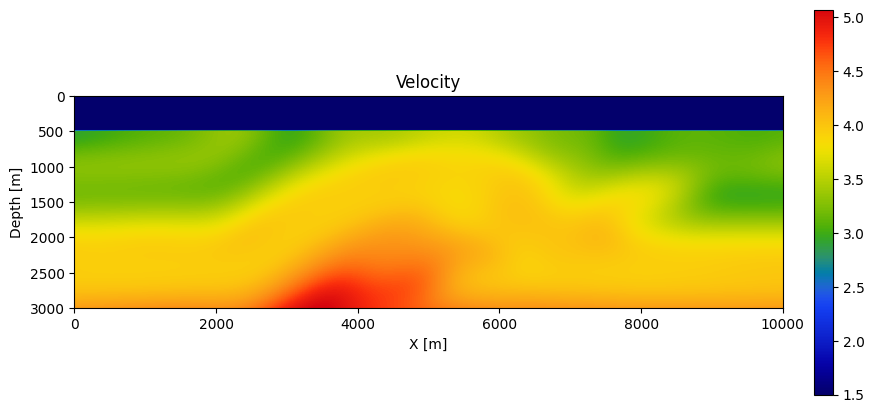

In [4]:
figure(figsize=(10, 5))
plot_velocity(m0'.^(-.5), d; aspect=1, new_fig=false, cbar=true)

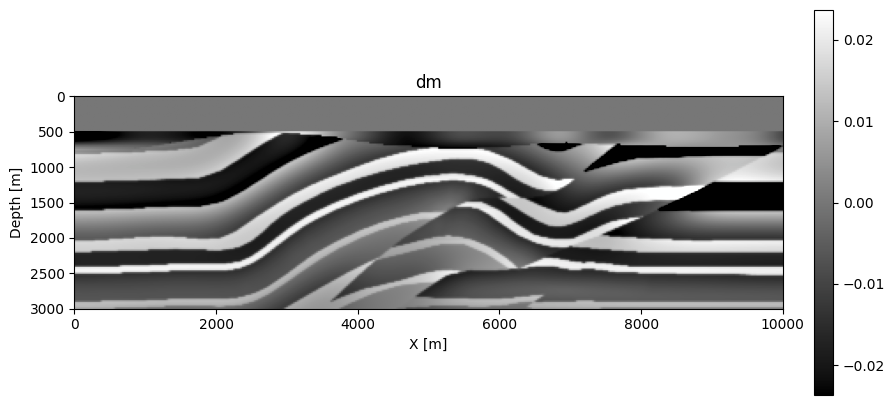

In [5]:
dm = m0 - m
figure(figsize=(10, 5))
plot_simage(dm', d; aspect=1, new_fig=false, cbar=true, name="dm")

In [6]:
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0)

Model (n=(401, 121), d=(25.0f0, 25.0f0), o=(0.0f0, 0.0f0)) with parameters [:m, :rho]

### Data
Now that we have a model, let's load and look at the data

In [7]:
block = segy_read("$(data_path)/overthrust_shot_records.segy")
d_obs = judiVector(block);  # linearized observed data
# Source
src_geometry = Geometry(block; key = "source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)    # 8 Hz wavelet
q = diff(judiVector(src_geometry, wavelet), dims=1)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO ~/.julia/dev/SegyIO/src/read/read_file.jl:36


judiVector{Float32, Matrix{Float32}} with 16 sources


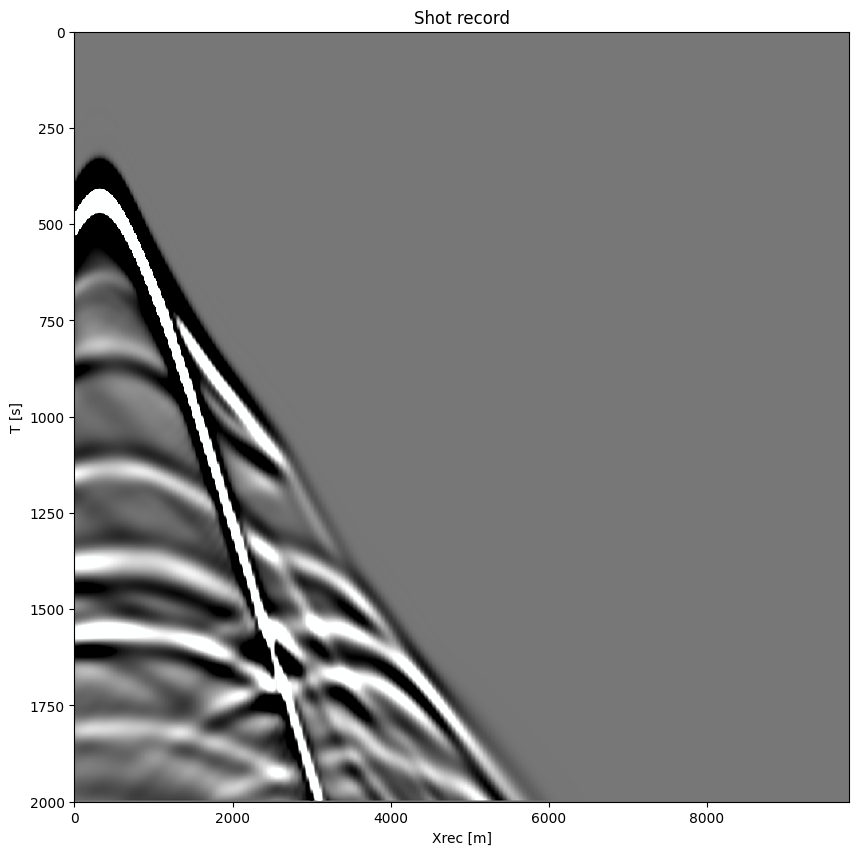

In [8]:
figure(figsize=(10, 10))
plot_sdata(get_data(d_obs[1]); new_fig=false)

since some of the preconditionners are designed for inversion, let's create the data forr the background model and the propagators needed for imaging and inversion


In [9]:
F = judiModeling(model, q.geometry, d_obs.geometry; options=Options(space_order=16))
J = judiJacobian(F(model0), q)
d0 = F(model0)*q

Building forward operator
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.27 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.27 s
Operator `forward` ran in 0.21 s
Operator `forward` ran in 0.24 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.26 s
Operator `forward` ran in 0.25 s
Operator `forward` ran in 0.23 s
Operator `forward` ran in 0.22 s
Operator `forward` ran in 0.22 s


judiVector{Float32, Matrix{Float32}} with 16 sources


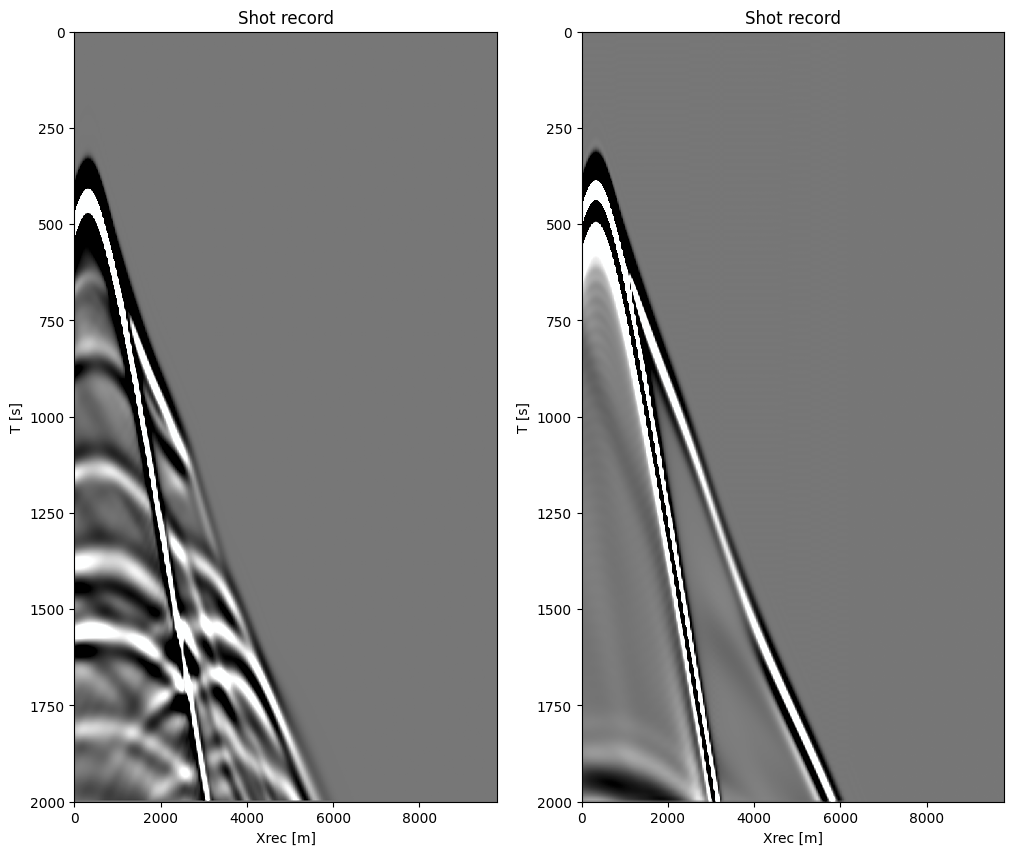

In [10]:
figure(figsize=(12, 10))
subplot(121)
plot_sdata(get_data(d_obs[1]); new_fig=false)
subplot(122)
plot_sdata(d0[1]; new_fig=false)

## Model preconditionners

In [11]:
Dm = judiDepthScaling(model0)
Tm = judiTopmute(model0; taperwidth=0)
Il = inv(judiIllumination(model0))
mcases = [(Dm, "Depth scaling"), (Tm, "Water layer mute"), (Il, "Illumination")]

┌ Warning: Deprecated model.n, use size(model)
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: Deprecated model.d, use spacing(model)
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: Deprecated model.o, use origin(model)
│   caller = ip:0x0
└ @ Core :-1


3-element Vector{Tuple{JUDI.ModelPreconditioner{Float32, Float32}, String}}:
 (DepthScaling{Float32, 2, 0.5f0}(48521, Float32[0.0 25.0 … 2975.0 3000.0]), "Depth scaling")
 (TopMute{Float32, 2, 1}(48521, [21, 21, 21, 21, 21, 21, 21, 21, 21, 21  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21], 0), "Water layer mute")
 (judiIllumination{Float32, :u, -1, true}("judiIllumination{Float32, :u, 1, true}", Dict{SubString{String}, PhysicalParameter{Float32, 2}}("u" => PhysicalParameter{Float32, 2} of size (401, 121) with origin (0.0f0, 0.0f0) and spacing (25.0f0, 25.0f0)), 48521), "Illumination")

In [12]:
rtm = J'*(d0 - d_obs)

Building forward operator
Operator `forward` ran in 0.11 s
Building adjoint born operator
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.28 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.27 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.27 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.27 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.27 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.11 s
Opera

PhysicalParameter{Float32, 2} of size (401, 121) with origin (0.0f0, 0.0f0) and spacing (25.0f0, 25.0f0)


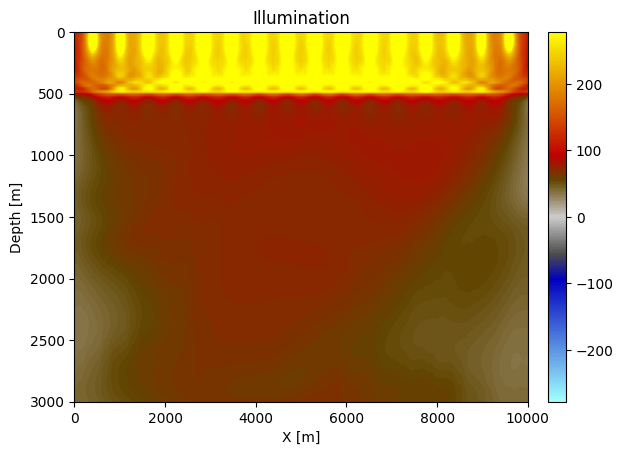

In [13]:
plot_simage(Il.illums["u"]'; cbar=true, name="Illumination")

### Model top mute

This preconditionner is one of the simplest one and mutes the water layer, or more generally sets to zeros the top of the model.

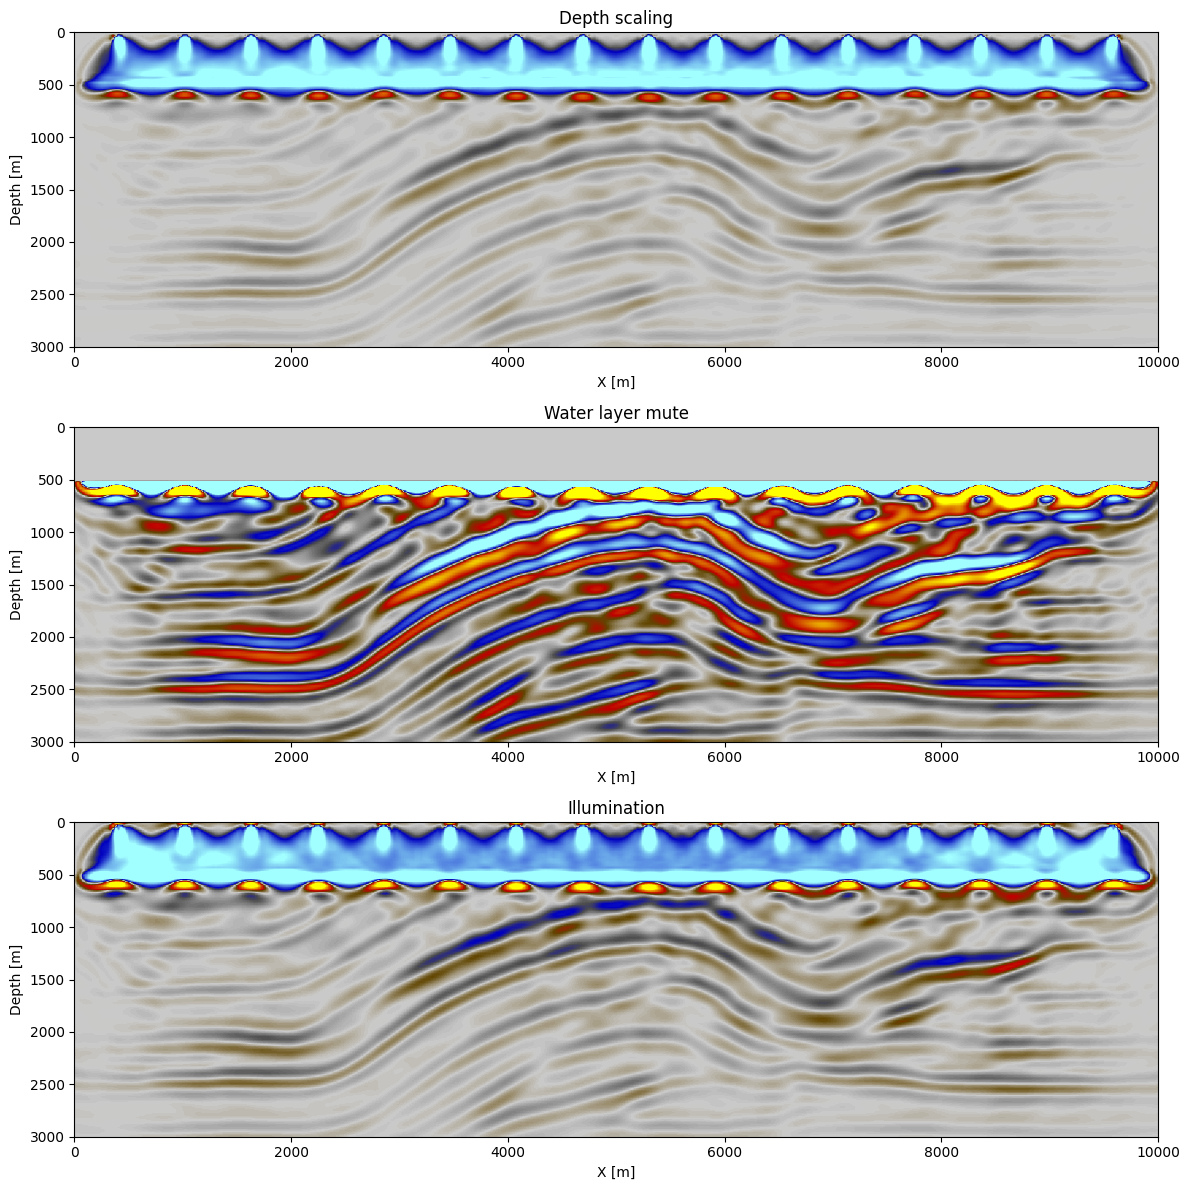

In [14]:
figure(figsize=(12, 12))
for (i, (pr, name)) in enumerate(mcases)
    subplot(3,1,i)
    plot_simage((pr*rtm)'; new_fig=false, name=name)
end
tight_layout()

## Data Preconditionners

In [15]:
Dt = judiTimeDerivative(d_obs, .5)
It = judiTimeIntegration(d_obs, .5)
Dmr = judiDataMute(q, d_obs; mode=:reflection, taperwidth=2)
Dmt = judiDataMute(q, d_obs; mode=:turning)
Df = judiFilter(d_obs, .1, 5.0)
dcases = [(Dt, "Fractional (.5) time derivative"),
         (It, "Fractional (.5) time integration"),
         (Dmr, "Turning waves muting"),
         (Dmt, "Reflection muting"),
         (Df, "bandpass filter [.1, 5]Hz")];

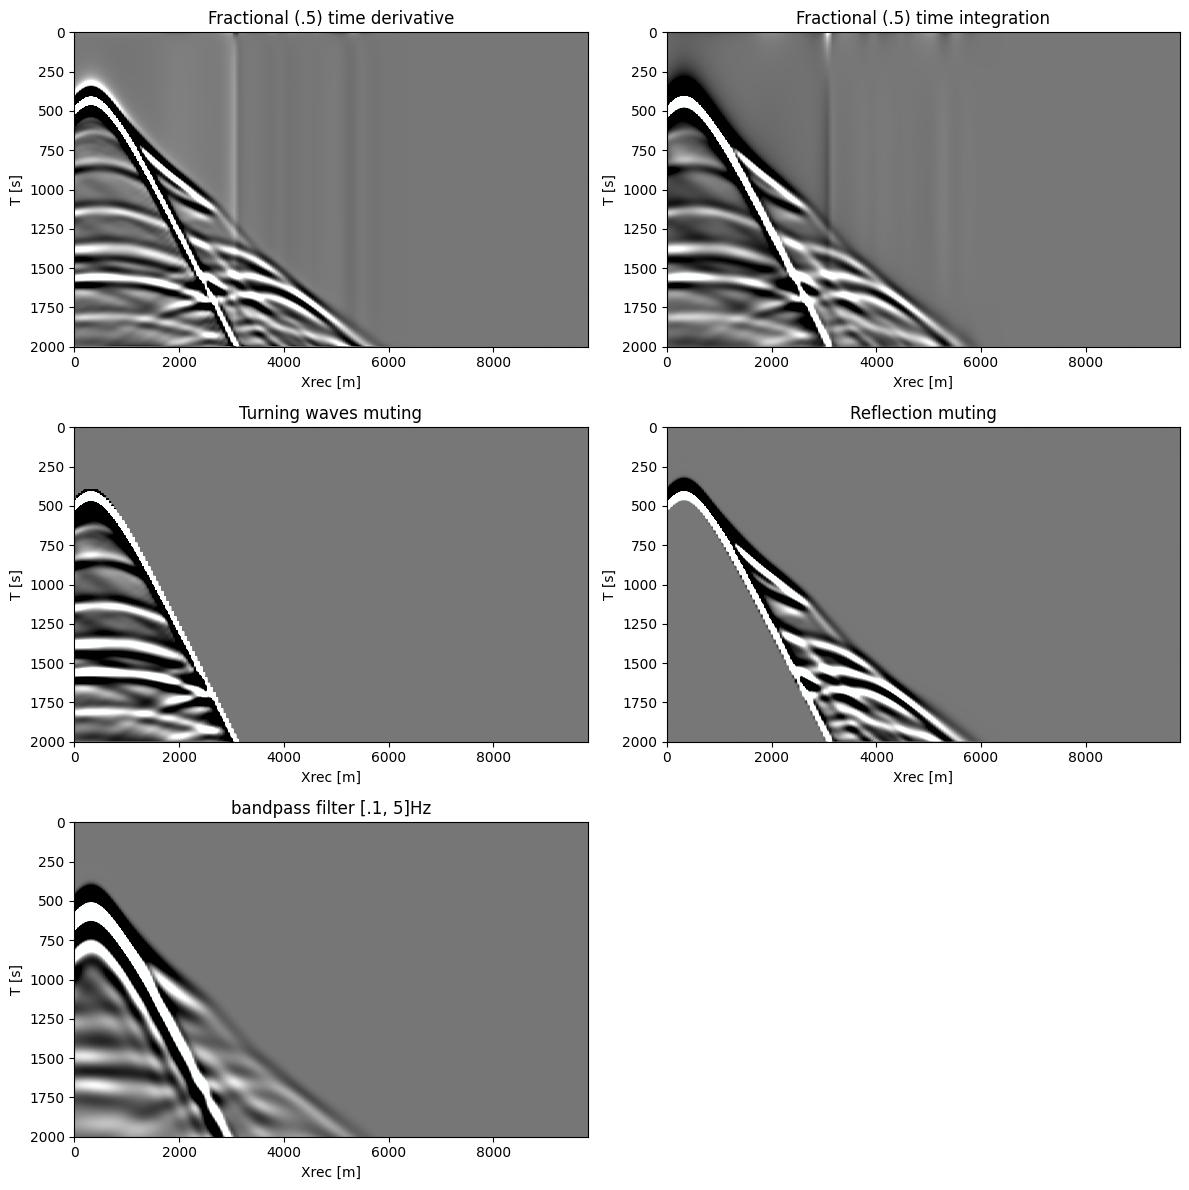

In [16]:
figure(figsize=(12, 12))
for (i, (pr, name)) in enumerate(dcases)
    subplot(3,2,i)
    dloc = (pr*d_obs)[1]
    plot_sdata(dloc; new_fig=false, name=name)
end
tight_layout()

## Putting it together

Of course, in practice numerous preconditionners would be needed for the best result. Since our implementation relies on linear algebra abstractions, those preconditionners can be used with each other and in combination with propagators as well. We show a few examples below

In [17]:
# Low frequency gradient with turing waves only for FWI
rtmlow = Il*Tm*J'* Dmt * Df * (d0 - d_obs);

Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.28 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.28 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.28 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.31 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.27 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.33 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

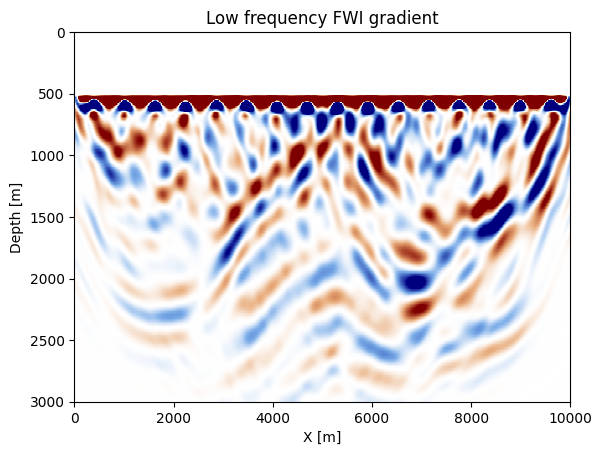

In [18]:
figure(figsize=(12, 4))
plot_simage(reshape(rtmlow, model.n)', model.d; new_fig=false, name="Low frequency FWI gradient", cmap=seiscm(:bwr))